<a href="https://www.kaggle.com/code/klyushnik/s5e6-blend-0-33408?scriptVersionId=246616178" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


# Description

![Optimal-Timing-for-Applying-NPK-Fertilizer.jpg](https://risso-chemical.com/wp-content/uploads/2024/09/Optimal-Timing-for-Applying-NPK-Fertilizer.jpg)

## Overview
Welcome to the 2025 Kaggle Playground Series! This competition aims to provide an engaging and approachable dataset for the community to practice their machine learning skills. Each month, we anticipate a new competition, and this month, we focus on predicting the optimal fertilizers for various weather, soil conditions, and crops.

## Your Goal
Your objective is to select the best fertilizer for different weather, soil conditions, and crops based on the provided dataset.

## Evaluation
Submissions are evaluated according to the **Mean Average Precision @ 3 (MAP@3)**, which is calculated using the following formula:

\$
\text{MAP@3} = \frac{1}{N} \sum_{i=1}^{N} P@k
\$

Where:
- \$ N \$ is the number of observations,
- \$ P@k \$ is the precision at cutoff \$ k \$,
- \$ k \$ is the number of predictions per observation,
- The indicator function equals 1 if the item at rank \$ k \$ is a relevant (correct) label, and zero otherwise.

Once a correct label has been scored for an observation, that label is no longer considered relevant for that observation, and additional predictions of that label are skipped in the calculation. For example, if the correct label is A for an observation, the following predictions all score an average precision of 1.0:
- [A, B, C, D, E]
- [A, A, A, A, A]
- [A, B, A, C, A]

## Submission File
For each `id` in the test set, you may predict up to 3 Fertilizer Name values, with the predictions space delimited. The file should contain a header and have the following format:


# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from scipy.optimize import minimize

from sklearn import preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    KBinsDiscretizer,
    StandardScaler
)
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    chi2,
    SequentialFeatureSelector,
)
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    train_test_split,
    cross_validate,
)
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization,
    Flatten,
    Dense,
    Dropout,
    Activation,
)
from keras import backend as K
import keras_tuner
from keras_tuner import RandomSearch, Hyperband

import optuna
from optuna.samplers import CmaEsSampler
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from catboost import CatBoostClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from category_encoders import TargetEncoder, MEstimateEncoder

import requests
import holidays
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
import re
import time
import logging
from functools import partial
from itertools import combinations
from IPython.display import Image

# Visualization settings
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Pandas settings
pd.options.mode.chained_assignment = None

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Warnings configuration
warnings.filterwarnings('ignore')

2025-06-21 06:14:12.413473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750486452.599259      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750486452.653051      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting

In [3]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        mean_value = df[feature].mean()
        axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Boxplot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        median_value = df[feature].median()
        axes[i].axvline(median_value, color='orange', linestyle='--', label='Median')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Theoretical Quantiles', fontsize=14)
        axes[i].set_ylabel('Sample Quantiles', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha= 0.7)  

    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features], diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'k'}, height=2.5)
    plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18, fontweight='bold')
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i], palette='viridis', order=top_categories)
        else:
            sns.countplot(data=df, y=feature, ax=axes[i], palette='viridis')
        
        axes[i].set_title(f'Count of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Count', fontsize=14)
        axes[i].set_ylabel(feature, fontsize=14)
        axes[i].tick_params(axis='y', rotation=0)
        axes[i].grid(True, linestyle='--', alpha=0.7)  
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
    """
    Optimizes memory usage in a DataFrame by downcasting numeric columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to optimize.
        print_size (bool): If True, prints memory usage before and after optimization.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in numerics:
            try:
                if str(column_type).startswith('int'):
                    df[column] = pd.to_numeric(df[column], downcast='integer')
                else:
                    df[column] = pd.to_numeric(df[column], downcast='float')
                logger.info(f"Optimized column {column}: {column_type} -> {df[column].dtype}")
            except Exception as e:
                logger.error(f"Failed to optimize column {column}: {e}")
    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    
    if print_size:
        print(
            'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(
                before_size, after_size, 100 * (before_size - after_size) / before_size
            )
        )
    
    return df

def categorize_variable(df, column, labels):
    
    if len(labels) != 3:
        raise ValueError("3 type")
    
    bins = [-float('inf'), 
            df[column].quantile(0.25), 
            df[column].quantile(0.75), 
            float('inf')]
    
    df[f'{column}_group'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

def replace_outliers_with_mean(df, threshold=3):

    df_clean = df.copy()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit')) 
        
        mean_val = df[col][z_scores <= threshold].mean()
        
        df_clean[col] = np.where(z_scores > threshold, mean_val, df[col])
        
    return df_clean

# Data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')

display(train.shape, test.shape)

display(train.info())

test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

display(train.head(5))

display(train.describe().T)

duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

(750000, 10)

(250000, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


None

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


,count,mean,std,min,25%,50%,75%,max
Temparature,750000.0,31.503565,4.025574,25.0,28.0,32.0,35.0,38.0
Humidity,750000.0,61.038912,6.647695,50.0,55.0,61.0,67.0,72.0
Moisture,750000.0,45.184147,11.794594,25.0,35.0,45.0,55.0,65.0
Nitrogen,750000.0,23.093808,11.216125,4.0,13.0,23.0,33.0,42.0
Potassium,750000.0,9.478296,5.765622,0.0,4.0,9.0,14.0,19.0
Phosphorous,750000.0,21.073227,12.346831,0.0,10.0,21.0,32.0,42.0


Number of duplicates: 0
Temparature - 0%
Humidity - 0%
Moisture - 0%
Soil Type - 0%
Crop Type - 0%
Nitrogen - 0%
Potassium - 0%
Phosphorous - 0%
Fertilizer Name - 0%
Memory usage size: before 51.4985 Mb - after 21.4578 Mb (58.3%).
Memory usage size: before 15.2589 Mb - after 5.2453 Mb (65.6%).


# EDA

## Numerical feature

### Hit

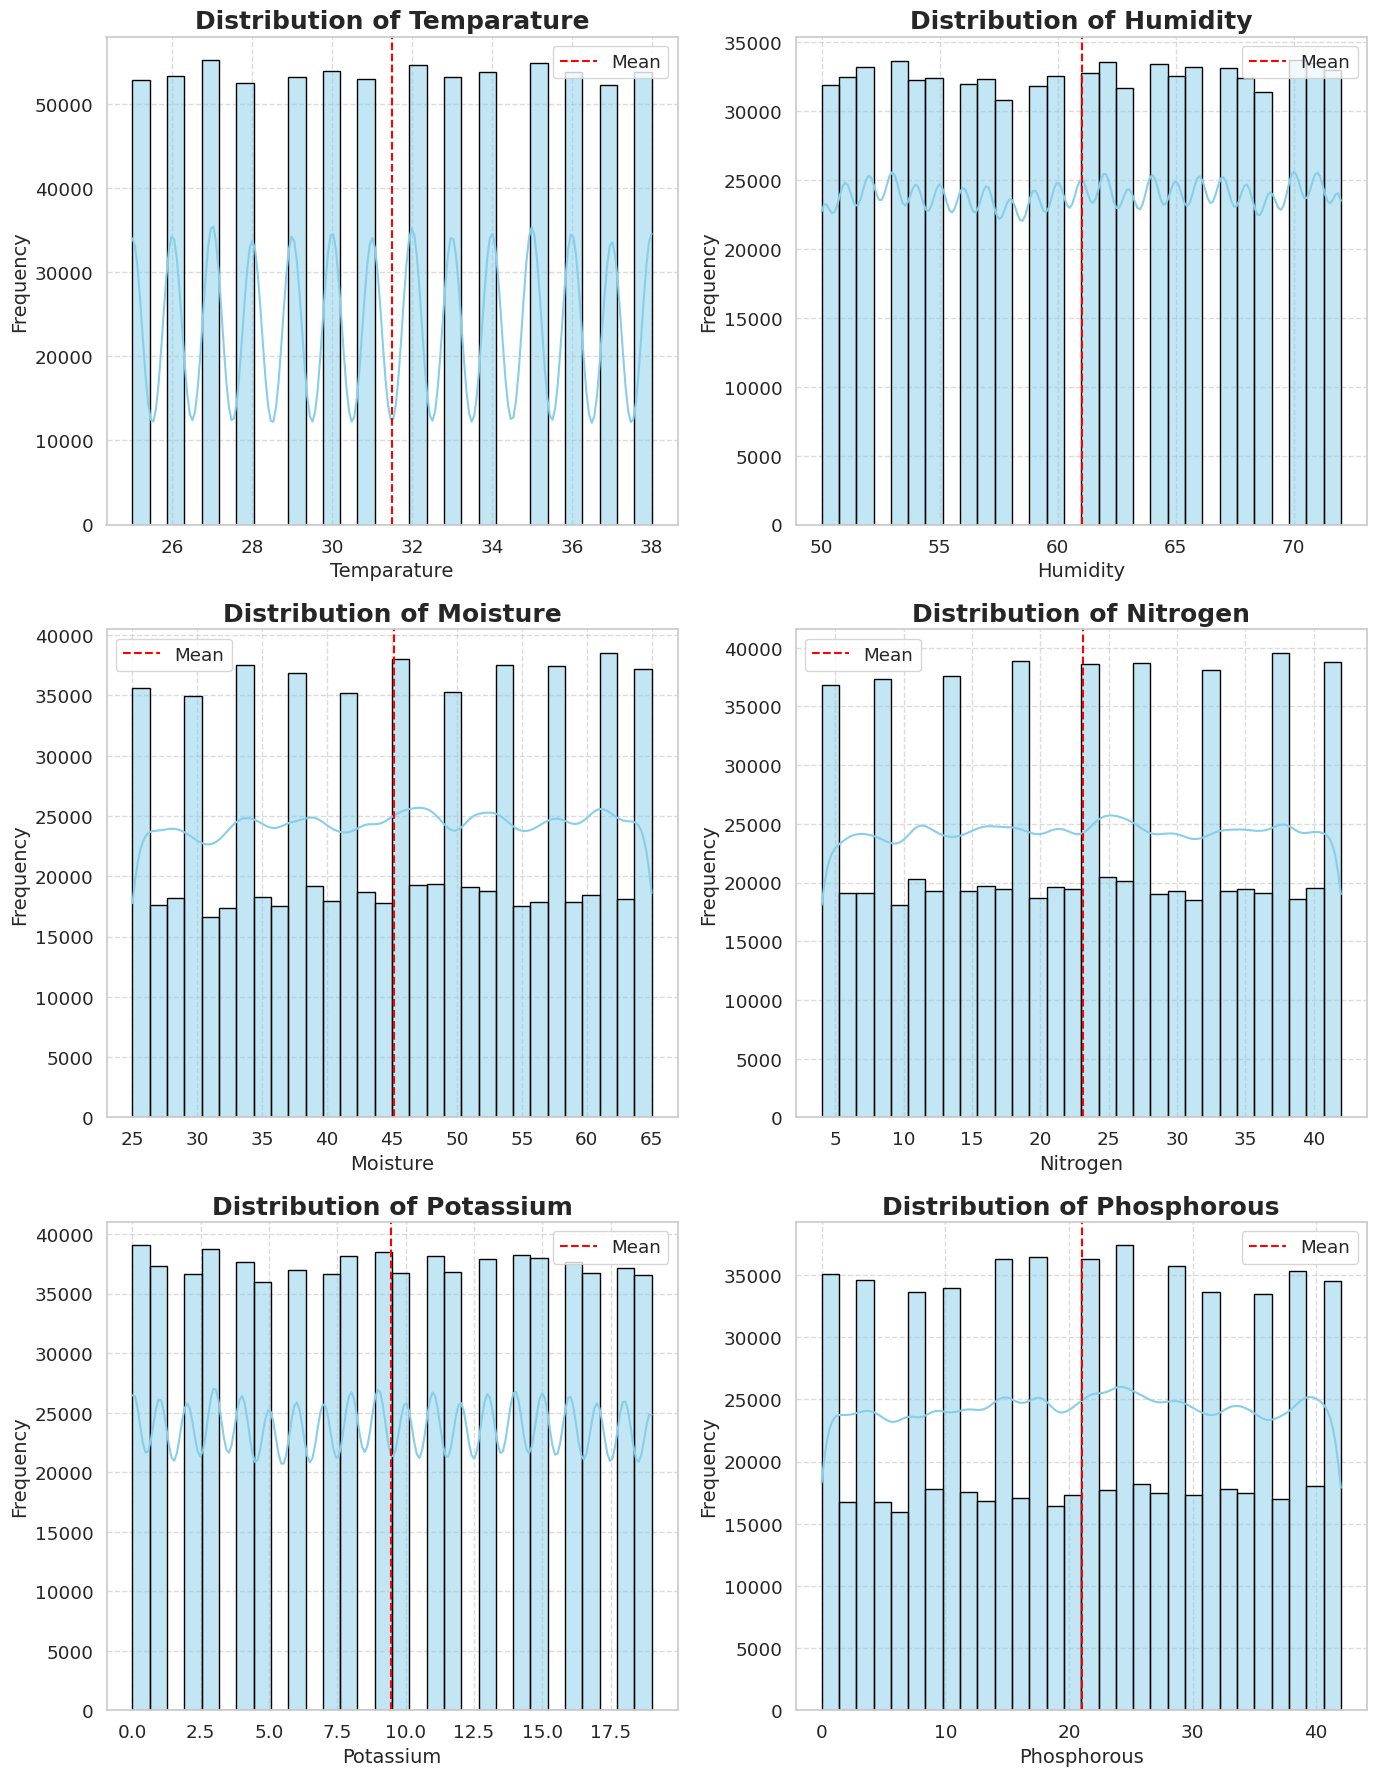

In [5]:
plot_numerical_features(train)

### Boxplot

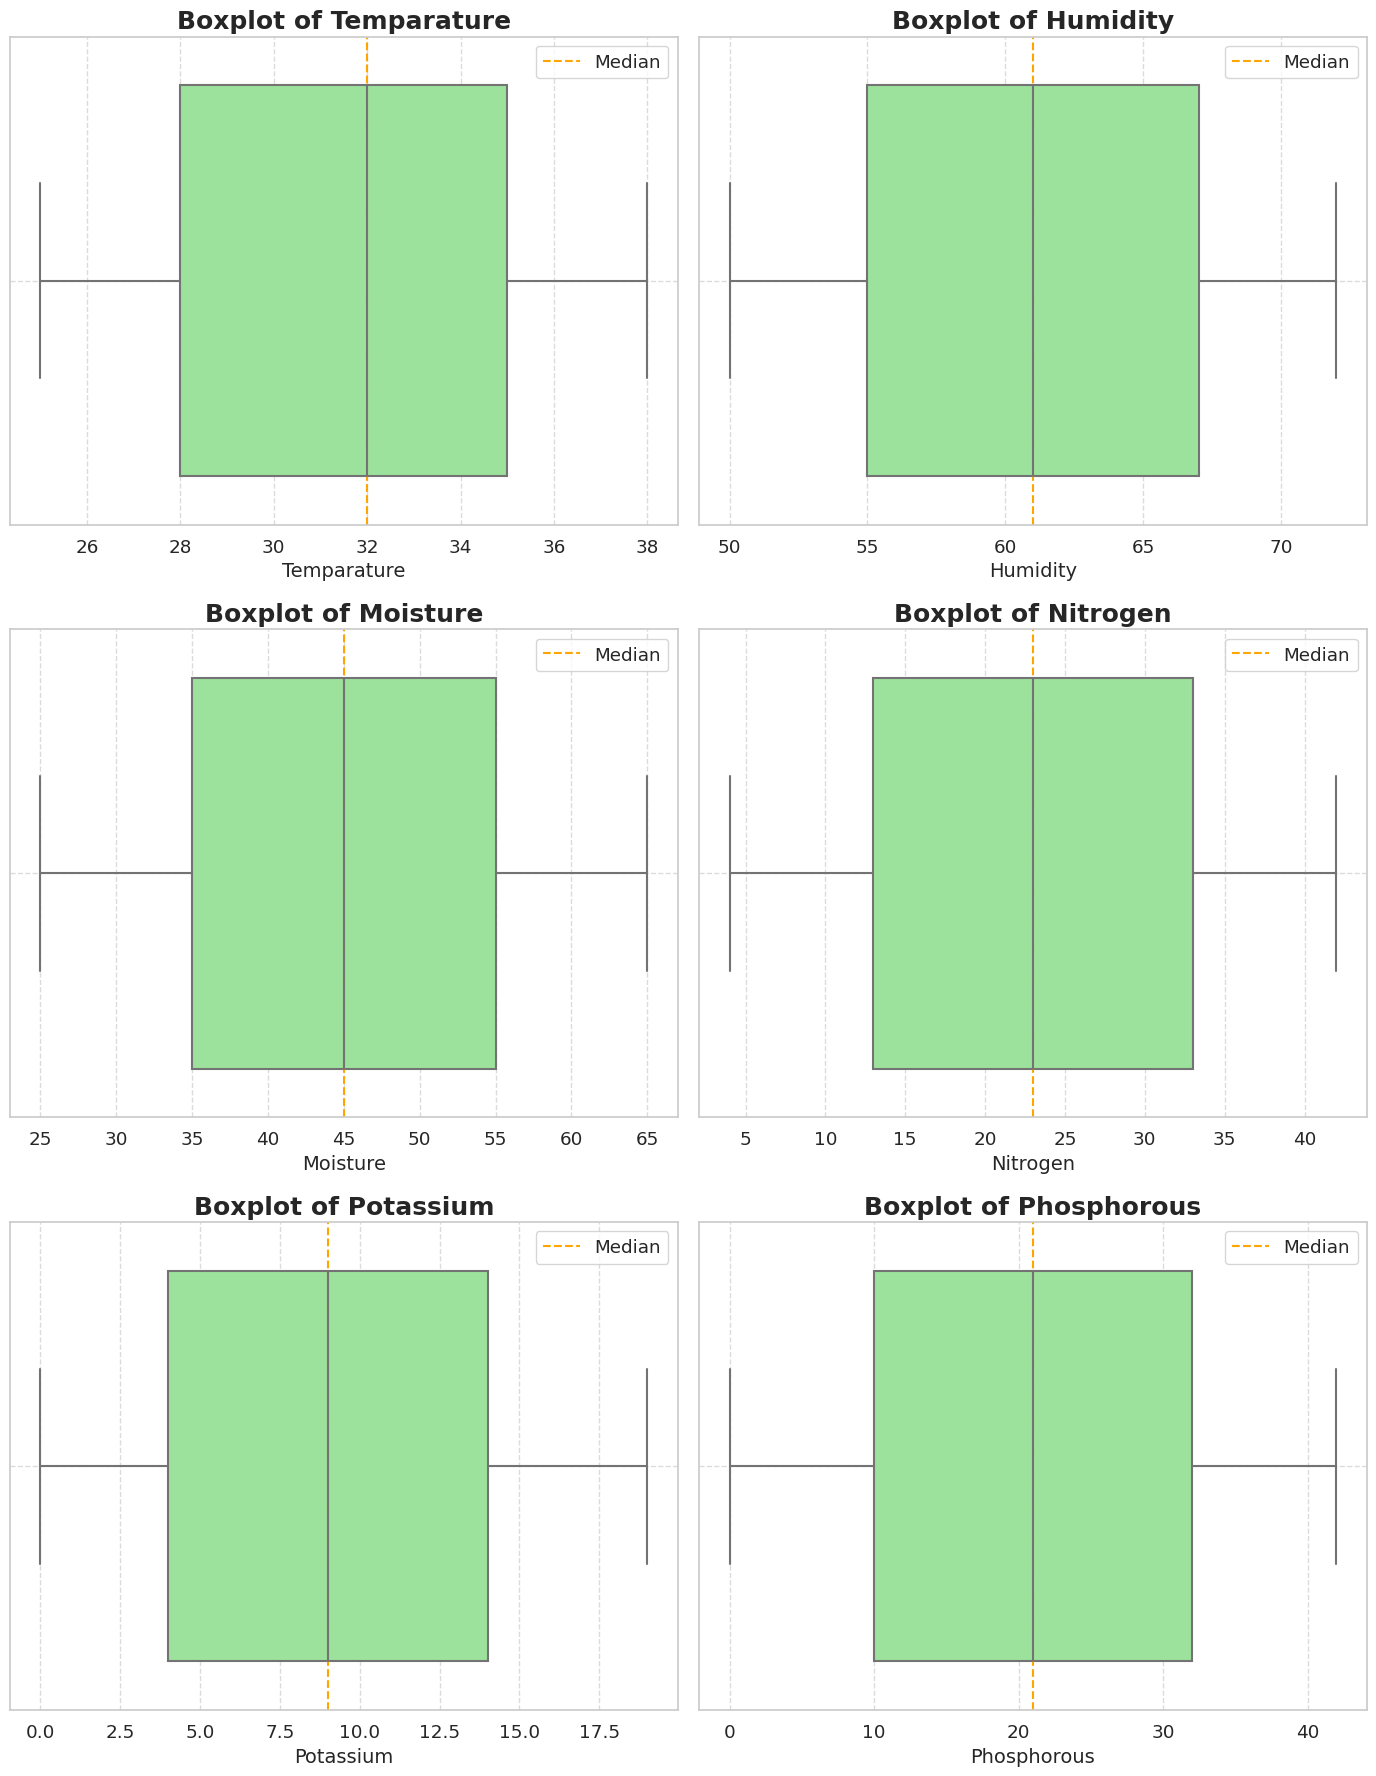

In [6]:
plot_numerical_boxplots(train)

### Q-Q plot

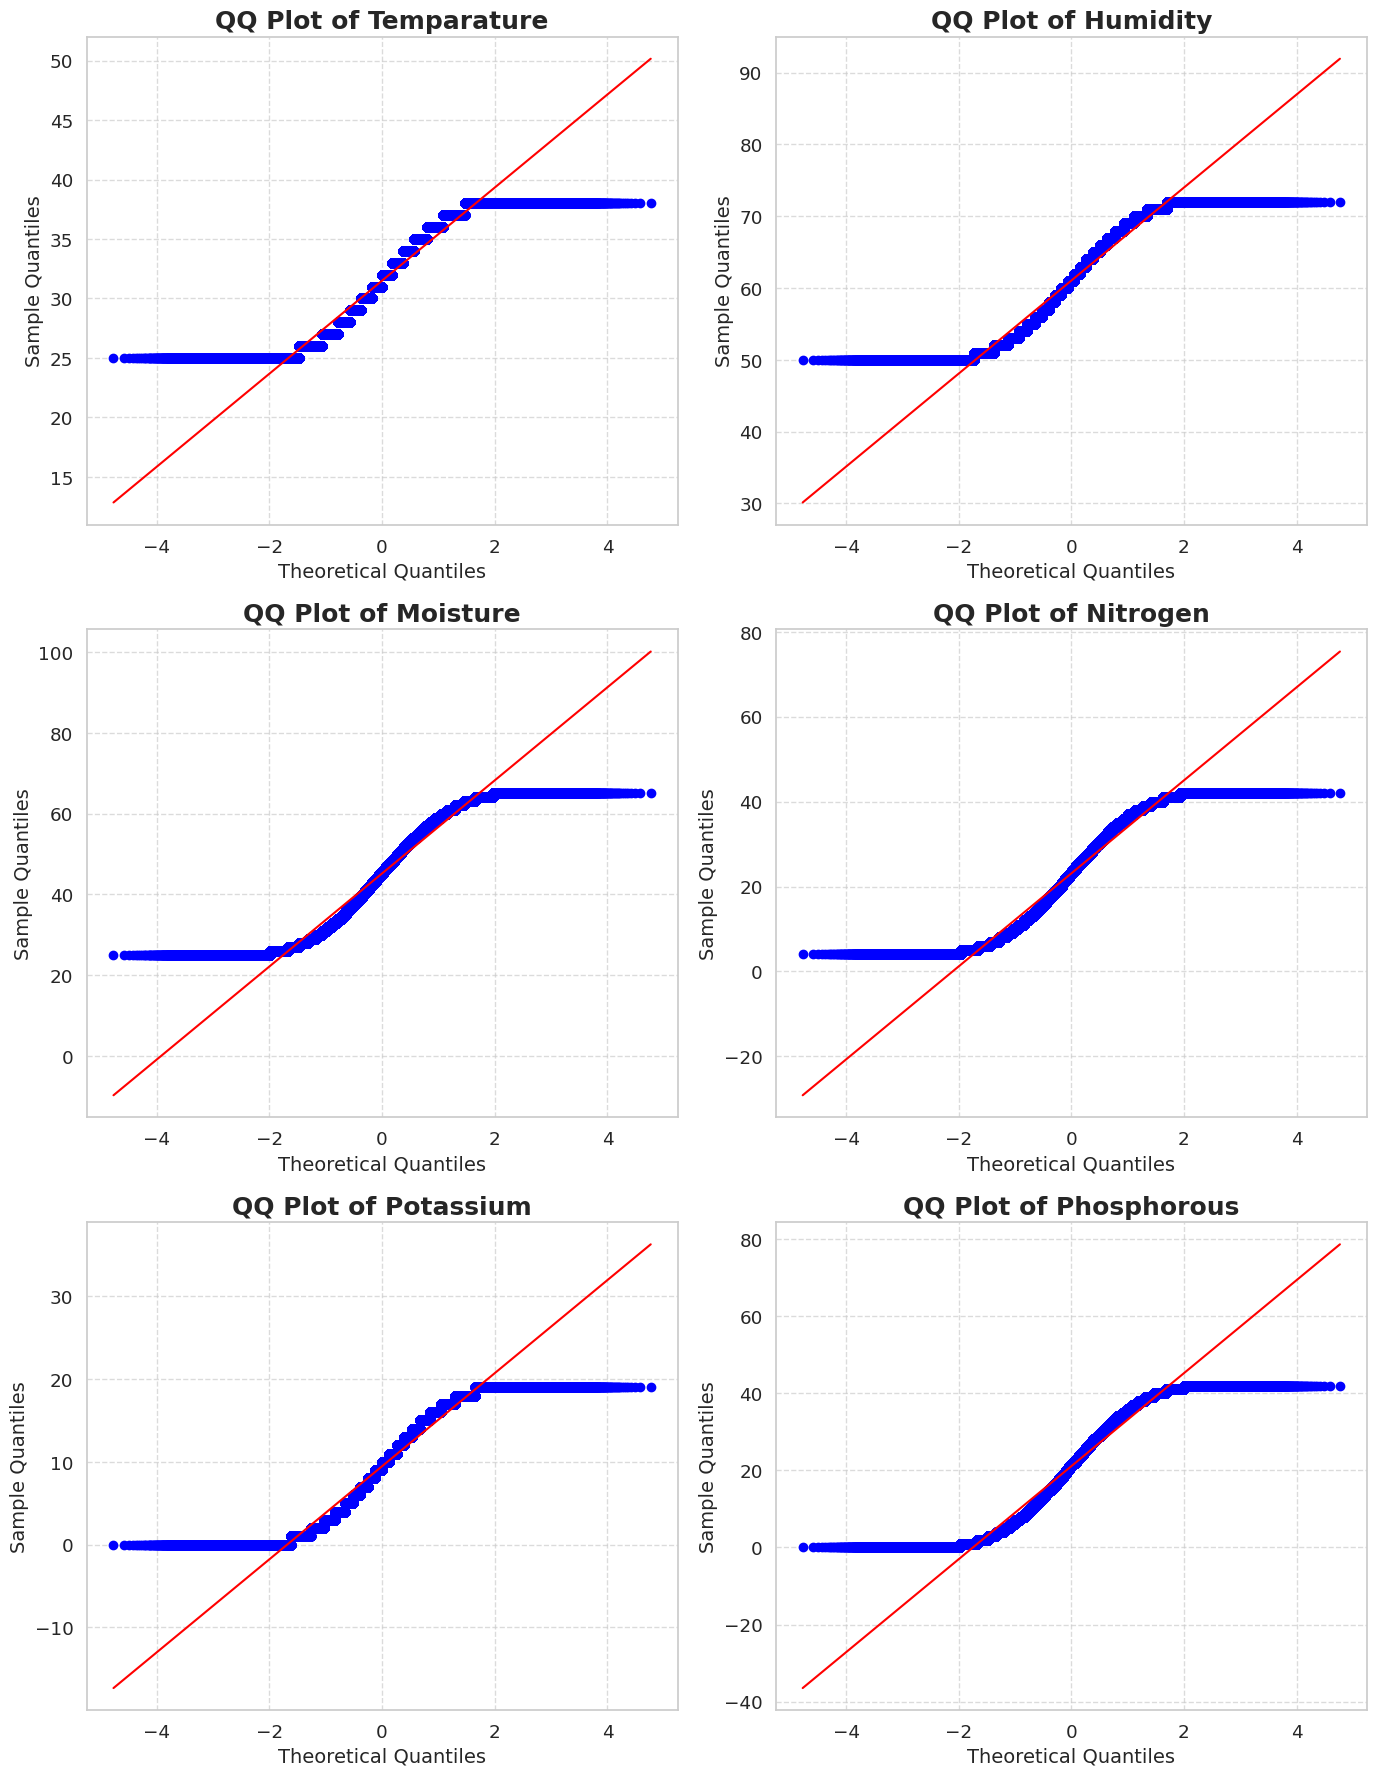

In [7]:
plot_qq_plot(train)

### correlation_matrix

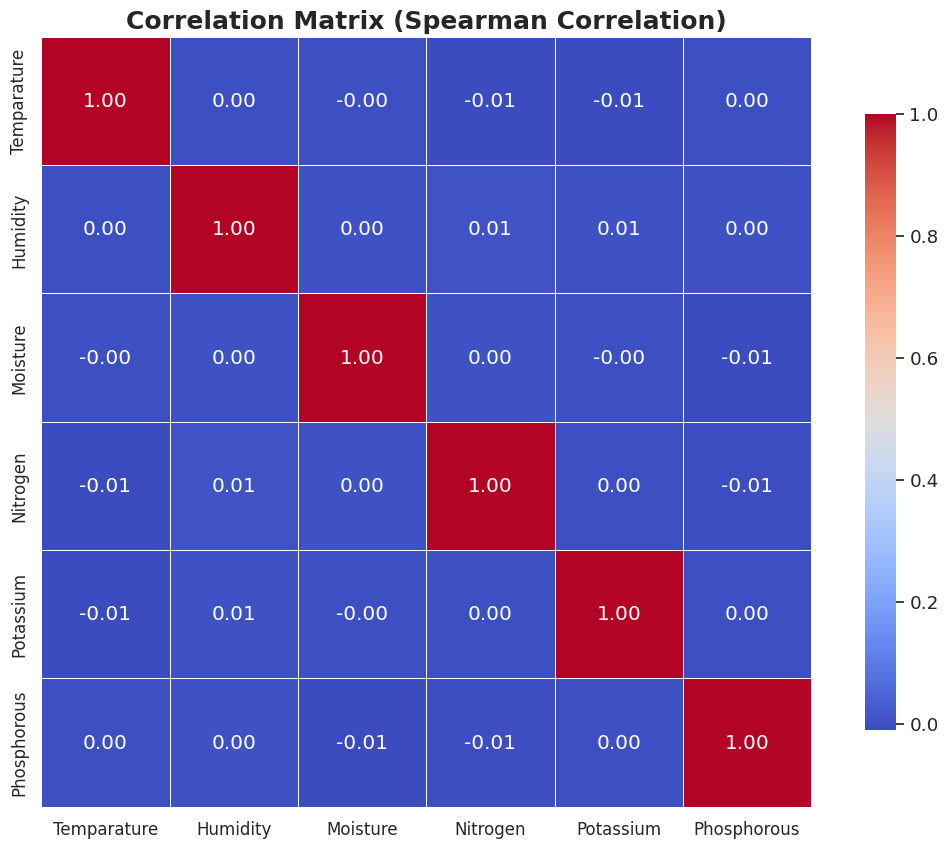

In [8]:
plot_correlation_matrix(train)

### VIF

In [9]:
X = sm.add_constant(train.select_dtypes(include=[np.number]).iloc [:, 1:])

VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

      Variable         VIF
0        const  109.226261
1     Humidity    1.000087
2     Moisture    1.000070
3     Nitrogen    1.000081
4    Potassium    1.000031
5  Phosphorous    1.000081


## Categorical features

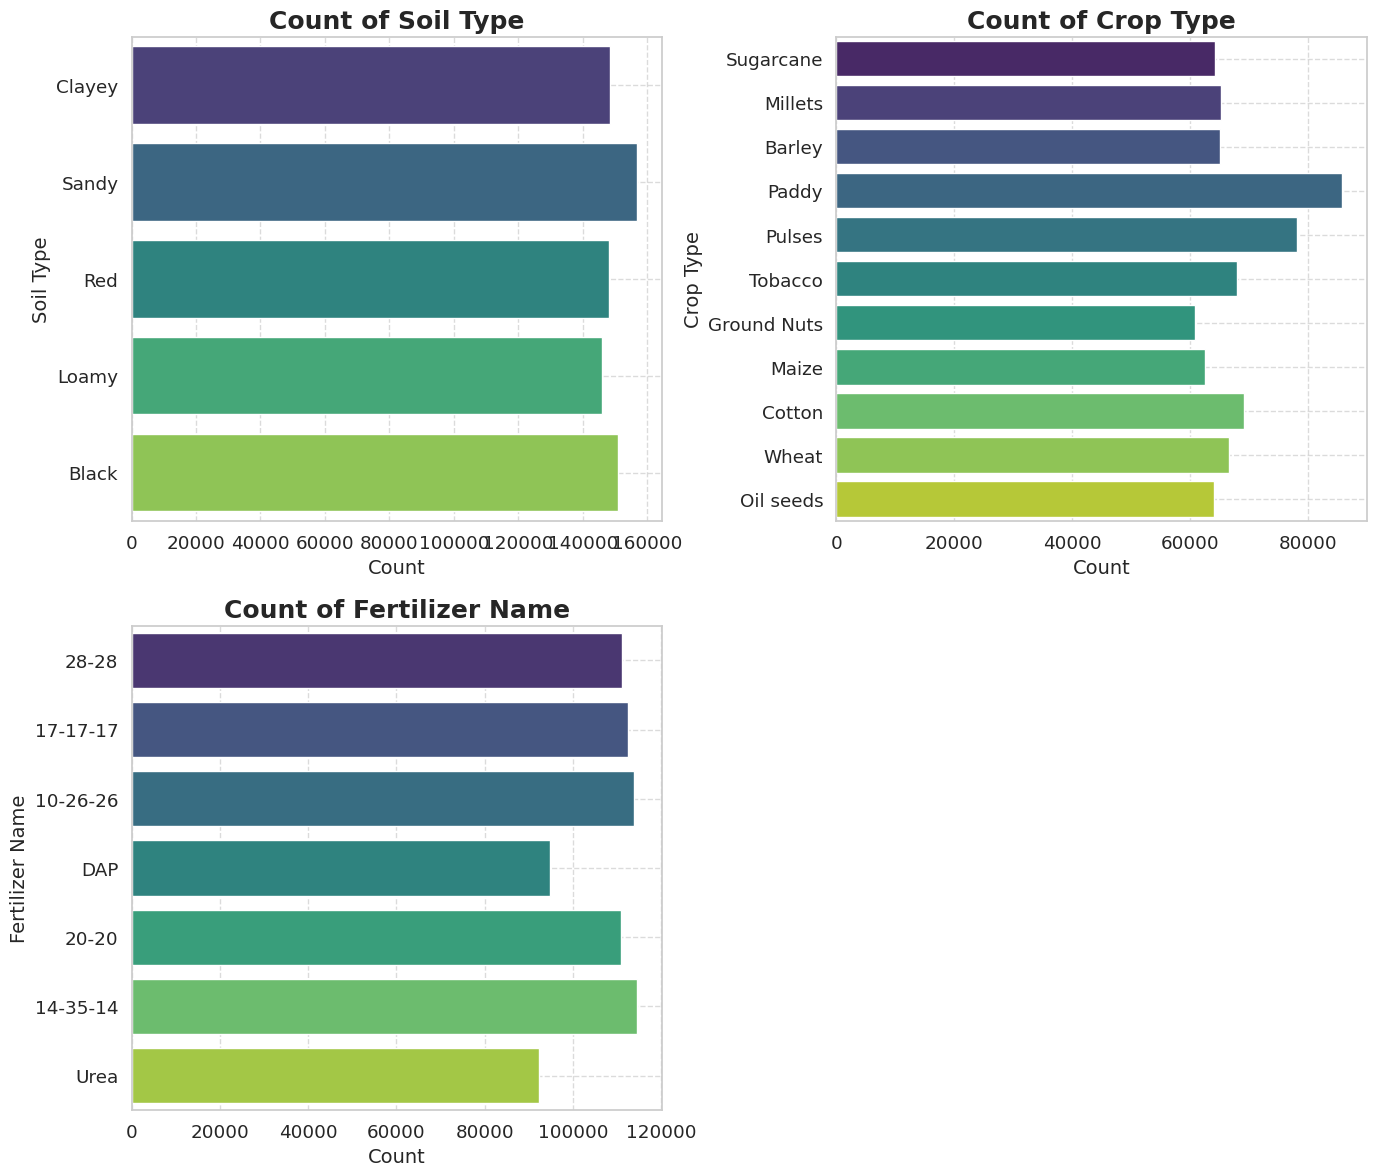

In [10]:
plot_categorical_features(train)

# New features

In [11]:
categorize_variable(train, 'Temparature', ["cold", "mean", "hot"])
categorize_variable(test, 'Temparature', ["cold", "mean", "hot"])
categorize_variable(train, 'Humidity', ["dry", "normal", "humid"])
categorize_variable(test, 'Humidity', ["dry", "normal", "humid"])
categorize_variable(train, 'Moisture', ["low", "medium", "high"])
categorize_variable(test, 'Moisture', ["low", "medium", "high"])
categorize_variable(train, 'Nitrogen', ["low", "medium", "high"])
categorize_variable(test, 'Nitrogen', ["low", "medium", "high"])
categorize_variable(train, 'Potassium', ["low", "medium", "high"])
categorize_variable(test, 'Potassium', ["low", "medium", "high"])
categorize_variable(train, 'Phosphorous', ["low", "medium", "high"])
categorize_variable(test, 'Phosphorous', ["low", "medium", "high"])

train.shape, test.shape

((750000, 15), (250000, 14))

# X,y make transform

In [12]:
col = ['Soil Type', 'Crop Type']

for c in col:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

le = LabelEncoder()
train['Fertilizer Name'] = le.fit_transform(train['Fertilizer Name'])

In [13]:
X = train.drop(columns=['Fertilizer Name'])
y = train['Fertilizer Name']

X.shape, y.shape, test.shape

((750000, 14), (750000,), (250000, 14))

In [14]:
scaler = StandardScaler()

X[X.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(X[X.select_dtypes(include=[np.number]).columns])
test[X.select_dtypes(include=[np.number]).columns] = scaler.transform(test[X.select_dtypes(include=[np.number]).columns])

X.shape, y.shape, test.shape

((750000, 14), (750000,), (250000, 14))

# Model

## Set model

In [15]:
def mapk(y_true, y_pred, k=3):
    """
    Correct MAP@3 implementation according to competition rules:
    - Stops after first correct prediction
    - Only counts first occurrence of correct label
    """
    ap = []
    for true, preds in zip(y_true, y_pred):
        score = 0.0
        for i, pred in enumerate(preds[:k]):
            if pred == true:
                score = 1.0 / (i + 1.0)
                break
        ap.append(score)
    return np.mean(ap)

def create_ensemble(X, y, test, n_folds=5, 
                   catboost_params=None, xgb_params=None, lgbm_params=None):
    """
    Create ensemble with customizable parameters for each model type.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Training features
    y : pd.Series
        Training target
    test : pd.DataFrame
        Test features
    n_folds : int
        Number of cross-validation folds
    catboost_params : list of dict
        List of parameter dictionaries for CatBoost models
    xgb_params : list of dict
        List of parameter dictionaries for XGBoost models
    lgbm_params : list of dict
        List of parameter dictionaries for LightGBM models
        
    Returns:
    --------
    tuple: (all_oof, all_test_preds, model_info)
    """
    FOLDS = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Prepare categorical features
    cat_cols = ['Soil Type', 'Crop Type', 'Temparature_group', 'Humidity_group',
               'Moisture_group', 'Nitrogen_group', 'Potassium_group', 'Phosphorous_group']
    
    # Convert to categorical dtype
    for col in cat_cols:
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
    
    # Default parameters if none provided
    if catboost_params is None:
        catboost_params = [{
            'iterations': 1000,
            'learning_rate': 0.05,
            'depth': 6,
            'l2_leaf_reg': 3,
            'border_count': 64,
            'verbose': 0,
            'loss_function': 'MultiClass',
            'random_state': 42
        }]
    
    if xgb_params is None:
        xgb_params = [{
            'n_estimators': 500,
            'learning_rate': 0.05,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'min_child_weight': 3,
            'objective': 'multi:softprob',
            'random_state': 42,
            'enable_categorical': True
        }]
    
    if lgbm_params is None:
        lgbm_params = [{
            'n_estimators': 500,
            'learning_rate': 0.05,
            'max_depth': -1,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'objective': 'multiclass',
            'random_state': 42
        }]
    
    all_oof = {}
    all_test_preds = {}
    models_info = []
    num_classes = len(np.unique(y))
    
    # Create model instances with parameters
    models = []
    
    # CatBoost models
    for i, params in enumerate(catboost_params, 1):
        model_name = f'cat_{i}'
        params['loss_function'] = params.get('loss_function', 'MultiClass')
        #params['num_class'] = num_classes
        models.append((model_name, CatBoostClassifier(
            **params,
            cat_features=cat_cols
        )))
        models_info.append({
            'name': model_name,
            'type': 'catboost',
            'params': params
        })
    
    # XGBoost models
    for i, params in enumerate(xgb_params, 1):
        model_name = f'xgb_{i}'
        params['objective'] = params.get('objective', 'multi:softprob')
        params['num_class'] = num_classes
        models.append((model_name, xgb.XGBClassifier(
            **params,
            enable_categorical=True
        )))
        models_info.append({
            'name': model_name,
            'type': 'xgboost',
            'params': params
        })
    
    # LightGBM models
    for i, params in enumerate(lgbm_params, 1):
        model_name = f'lgb_{i}'
        params['objective'] = params.get('objective', 'multiclass')
        params['num_class'] = num_classes
        models.append((model_name, LGBMClassifier(
            **params,
            categorical_feature=cat_cols
        )))
        models_info.append({
            'name': model_name,
            'type': 'lightgbm',
            'params': params
        })
    
    # Train models
    for name, model in models:
        print(f"\nTraining {name}...")
        oof_preds = np.zeros((len(X), num_classes))
        test_preds = np.zeros((len(test), num_classes))
        
        for fold, (trn_idx, val_idx) in enumerate(FOLDS.split(X, y)):
            X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
            
            try:
                if name.startswith('cat_'):
                    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
                else:
                    model.fit(X_train, y_train)
                
                oof_preds[val_idx] = model.predict_proba(X_val)
                test_preds += model.predict_proba(test) / FOLDS.n_splits
                
                fold_top3 = np.argsort(oof_preds[val_idx], axis=1)[:, -3:][:, ::-1]
                fold_map3 = mapk(y_val.values, fold_top3)
                print(f'{name} - Fold {fold+1} MAP@3: {fold_map3:.4f}')
            
            except Exception as e:
                print(f"Error in {name} Fold {fold+1}: {str(e)}")
                continue
        
        all_oof[name] = oof_preds
        all_test_preds[name] = test_preds
        
        full_top3 = np.argsort(oof_preds, axis=1)[:, -3:][:, ::-1]
        full_map3 = mapk(y.values, full_top3)
        print(f'{name} - Full OOF MAP@3: {full_map3:.4f}')
    
    return all_oof, all_test_preds, models_info

## Fit

In [16]:
my_cat_params = [
    {
        'iterations': 700,
        'depth': 8,
        'learning_rate': 0.05,
        'l2_leaf_reg': 3,
        'early_stopping_rounds': 50,
        'border_count': 64,  # Slightly higher may be OK for some GPUs
        'early_stopping_rounds': 100,
        'task_type': 'GPU',
        'devices': '0',
        'gpu_ram_part': 0.8,
        'sampling_frequency': 'PerTree',
        'bootstrap_type': 'None',
    },
    {
        'iterations': 700,
        'depth': 10,
        'learning_rate': 0.03,
        'l2_leaf_reg': 5,
        'early_stopping_rounds': 100,
        'border_count': 32,  # Slightly higher may be OK for some GPUs
        'early_stopping_rounds': 100,
        'task_type': 'GPU',
        'devices': '0',
        'gpu_ram_part': 0.8,
        'sampling_frequency': 'PerTree',
        'bootstrap_type': 'None',
    }
]

my_xgb_params = [
    {
        'n_estimators': 700,
         "tree_method": "hist",
        "device": "cuda",
        'max_depth': 8,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0
    },
    {
        'n_estimators': 700,
         "tree_method": "hist",
        "device": "cuda",
        'max_depth': 10,
        'learning_rate': 0.03,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'gamma': 0.1
    }
]

my_lgbm_params = [
    {
        'n_estimators': 700,
        'max_depth': 8,
        'learning_rate': 0.01,
        'num_leaves': 31,
        'feature_fraction': 0.8,
         'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'gpu_use_dp': False,
        'max_bin': 63,
    },
    {
        'n_estimators': 700,
        'max_depth': 10,
        'learning_rate': 0.03,
        'num_leaves': 63,
        'feature_fraction': 0.9,
         'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'gpu_use_dp': False,
        'max_bin': 63,
    }
]

oof_results, test_predictions, models_info = create_ensemble(
    X, y, test,
    catboost_params=my_cat_params,
    xgb_params=my_xgb_params,
    lgbm_params=my_lgbm_params
)


Training cat_1...
Error in cat_1 Fold 1: tools/enum_parser/enum_serialization_runtime/enum_runtime.cpp:70: Key 'None' not found in enum EBootstrapType. Valid options are: 'Poisson', 'Bayesian', 'Bernoulli', 'MVS', 'No'. 
Error in cat_1 Fold 2: tools/enum_parser/enum_serialization_runtime/enum_runtime.cpp:70: Key 'None' not found in enum EBootstrapType. Valid options are: 'Poisson', 'Bayesian', 'Bernoulli', 'MVS', 'No'. 
Error in cat_1 Fold 3: tools/enum_parser/enum_serialization_runtime/enum_runtime.cpp:70: Key 'None' not found in enum EBootstrapType. Valid options are: 'Poisson', 'Bayesian', 'Bernoulli', 'MVS', 'No'. 
Error in cat_1 Fold 4: tools/enum_parser/enum_serialization_runtime/enum_runtime.cpp:70: Key 'None' not found in enum EBootstrapType. Valid options are: 'Poisson', 'Bayesian', 'Bernoulli', 'MVS', 'No'. 
Error in cat_1 Fold 5: tools/enum_parser/enum_serialization_runtime/enum_runtime.cpp:70: Key 'None' not found in enum EBootstrapType. Valid options are: 'Poisson', 'Baye

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (9.16 MB) transferred to GPU in 0.012920 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.884862
[LightGBM] [Info] Start training from score -1.880055
[LightGBM] [Info] Start training from score -1.897542
[LightGBM] [Info] Start training from score -1.911546
[LightGBM] [Info] Start training from score -1.909125
[LightGBM] [Info] Start training from score -2.067671
[LightGBM] [Info] Start training from score -2.094839
[LightGBM] [Warning] Unknown parameter: Type,Temparature_group,Humidity_group,Moisture_group,Nitrogen_group,Potassium_group,Phosphorous_group
[LightGBM] [Warning] Unknown parameter: Type,Crop
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Unknown parameter: Type,Temparature_group,Humidity_group,Moisture_group,Nitr

## Blend

In [17]:
def blend_predictions(oof_results, test_predictions, y_true):

    model_names = list(oof_results.keys())
    num_classes = oof_results[model_names[0]].shape[1]
    
    oof_top3 = {
        name: np.argsort(preds, axis=1)[:, -3:][:, ::-1] 
        for name, preds in oof_results.items()
    }
    
    model_scores = {
        name: mapk(y_true, top3) 
        for name, top3 in oof_top3.items()
    }
    
    print("\nIndividual Model Scores (MAP@3):")
    for name, score in model_scores.items():
        print(f"{name}: {score:.4f}")
    
    def objective(weights):
        weights = np.array(weights)
        weights = weights / np.sum(weights)
        
        blended = np.zeros_like(oof_results[model_names[0]])
        for i, name in enumerate(model_names):
            blended += weights[i] * oof_results[name]
        
        top3 = np.argsort(blended, axis=1)[:, -3:][:, ::-1]
        return mapk(y_true, top3)  
    
    bounds = [(0, 1) for _ in model_names]
    initial_weights = np.array([1/len(model_names)] * len(model_names))
    
    result = minimize(
        lambda w: -objective(w),  
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        options={'maxiter': 100}
    )
    
    if not result.success:
        print("\nOptimization warning:", result.message)
        optimal_weights = initial_weights
    else:
        optimal_weights = result.x / np.sum(result.x)  
    
    print("\nOptimized Weights:")
    for name, weight in zip(model_names, optimal_weights):
        print(f"{name}: {weight:.4f} (original score: {model_scores[name]:.4f})")
    
    final_oof = np.zeros_like(oof_results[model_names[0]])
    for i, name in enumerate(model_names):
        final_oof += optimal_weights[i] * oof_results[name]
    
    final_top3 = np.argsort(final_oof, axis=1)[:, -3:][:, ::-1]
    final_score = mapk(y_true, final_top3)
    print(f"\nFinal Blended OOF MAP@3: {final_score:.4f}")
    
    final_test_pred = np.zeros_like(test_predictions[model_names[0]])
    for i, name in enumerate(model_names):
        final_test_pred += optimal_weights[i] * test_predictions[name]
    
    return final_test_pred, optimal_weights


blended_test_pred, optimal_weights = blend_predictions(oof_results, test_predictions, y)


Individual Model Scores (MAP@3):
cat_1: 0.2357
cat_2: 0.2357
xgb_1: 0.3291
xgb_2: 0.3373
lgb_1: 0.3231
lgb_2: 0.3319

Optimized Weights:
cat_1: 0.1667 (original score: 0.2357)
cat_2: 0.1667 (original score: 0.2357)
xgb_1: 0.1667 (original score: 0.3291)
xgb_2: 0.1667 (original score: 0.3373)
lgb_1: 0.1667 (original score: 0.3231)
lgb_2: 0.1667 (original score: 0.3319)

Final Blended OOF MAP@3: 0.3368


# Submit

In [18]:
def create_submission(blended_preds, le, sample_sub_path, output_path='submission.csv'):
    # Get top-3 predictions
    top3_indices = np.argsort(blended_preds, axis=1)[:, -3:][:, ::-1]
    
    # Decode fertilizer names
    fertilizer_names = []
    for row in top3_indices:
        names = le.inverse_transform(row)
        fertilizer_names.append(' '.join(names))
    
    # Load sample submission
    sample_sub = pd.read_csv(sample_sub_path)
    
    # Create submission
    submission = sample_sub[['id']].copy()
    submission['Fertilizer Name'] = fertilizer_names
    
    # Save
    submission.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")
    print("\nSubmission head:")
    print(submission.head())
    
    return submission

# Usage
submission = create_submission(
    blended_test_pred, 
    le,
    '/kaggle/input/playground-series-s5e6/sample_submission.csv'
)

Submission saved to submission.csv

Submission head:
       id          Fertilizer Name
0  750000       28-28 DAP 17-17-17
1  750001  17-17-17 20-20 10-26-26
2  750002     20-20 28-28 10-26-26
3  750003   14-35-14 17-17-17 Urea
4  750004     20-20 10-26-26 28-28
